# Toronto Trendspotter: Recommendation System Analysis

This notebook analyzes the performance of our recommendation system and provides visualizations of the recommendation patterns. We'll evaluate how well the system is capturing Toronto-specific trends and user preferences.

In [1]:
# Import necessary libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random
from pymongo import MongoClient
from dotenv import load_dotenv
from collections import defaultdict

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import recommendation models
from src.models.collaborative_filtering import CollaborativeFiltering
from src.models.content_based import ContentBasedRecommender
from src.models.hybrid_recommender import HybridRecommender
from src.utils.db import get_mongodb_db

# Set up matplotlib for better visualizations
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Connect to MongoDB
load_dotenv()
db = get_mongodb_db()

print("Notebook set up successfully!")

2025-04-18 18:51:13,501 - src.utils.db - INFO - Successfully connected to MongoDB Atlas


Notebook set up successfully!


## 1. Data Overview

Let's start by exploring the data we have in our MongoDB database.

In [2]:
# Get collection statistics
content_count = db.content.count_documents({})
user_count = db.users.count_documents({})
event_count = db.toronto_events.count_documents({})
interaction_count = db.interactions.count_documents({})
feature_count = db.feature_vectors.count_documents({})

print(f"Database Contents:")
print(f"- Content items: {content_count}")
print(f"- Users: {user_count}")
print(f"- Toronto events: {event_count}")
print(f"- User interactions: {interaction_count}")
print(f"- Feature vectors: {feature_count}")

Database Contents:
- Content items: 1800
- Users: 400
- Toronto events: 500
- User interactions: 9636
- Feature vectors: 3600


### Content Distribution by Category

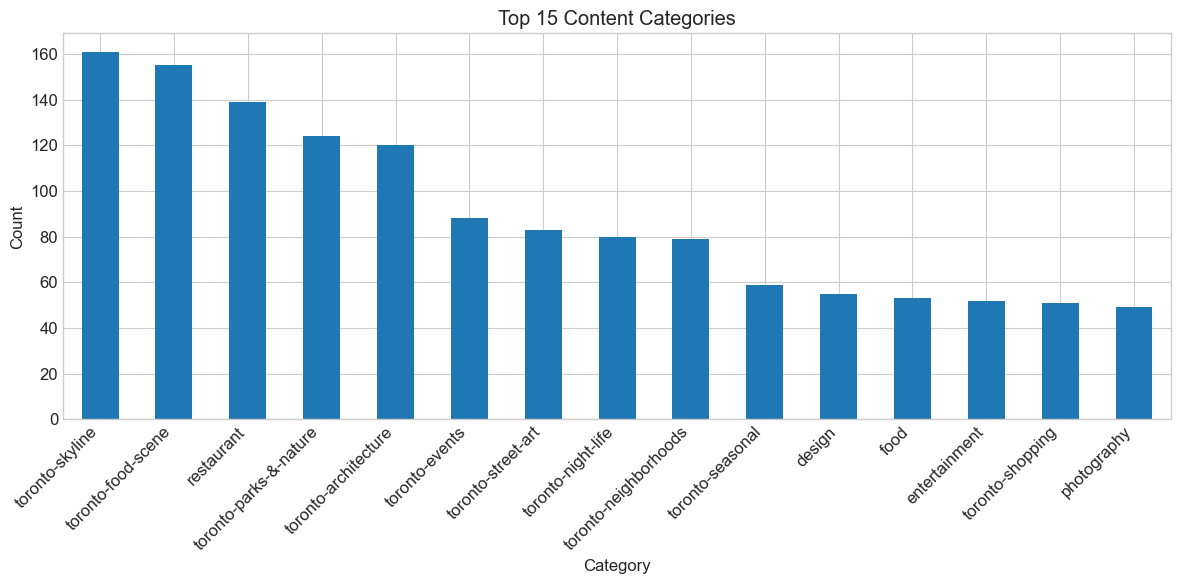

In [3]:
# Analyze content categories
all_categories = []
for item in db.content.find({}, {"categories": 1}):
    all_categories.extend(item.get("categories", []))

# Count frequency
category_counts = pd.Series(all_categories).value_counts().sort_values(ascending=False)

# Plot top 15 categories
plt.figure(figsize=(12, 6))
category_counts.head(15).plot(kind='bar')
plt.title('Top 15 Content Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Content Distribution by Neighborhood

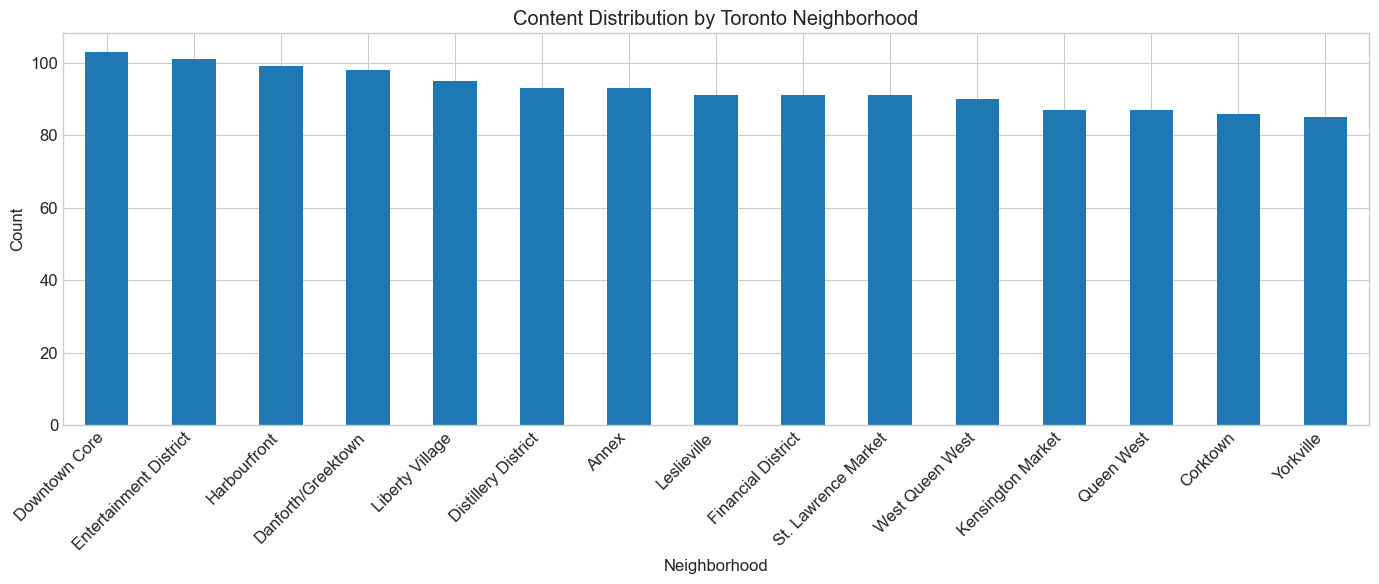

In [4]:
# Analyze neighborhood distribution
neighborhoods = []
for item in db.content.find({"location.neighborhood": {"$exists": True}}, {"location.neighborhood": 1}):
    neighborhood = item.get("location", {}).get("neighborhood")
    if neighborhood:
        neighborhoods.append(neighborhood)

# Count frequency
neighborhood_counts = pd.Series(neighborhoods).value_counts().sort_values(ascending=False)

# Plot neighborhoods
plt.figure(figsize=(14, 6))
neighborhood_counts.head(15).plot(kind='bar')
plt.title('Content Distribution by Toronto Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### User Interaction Analysis

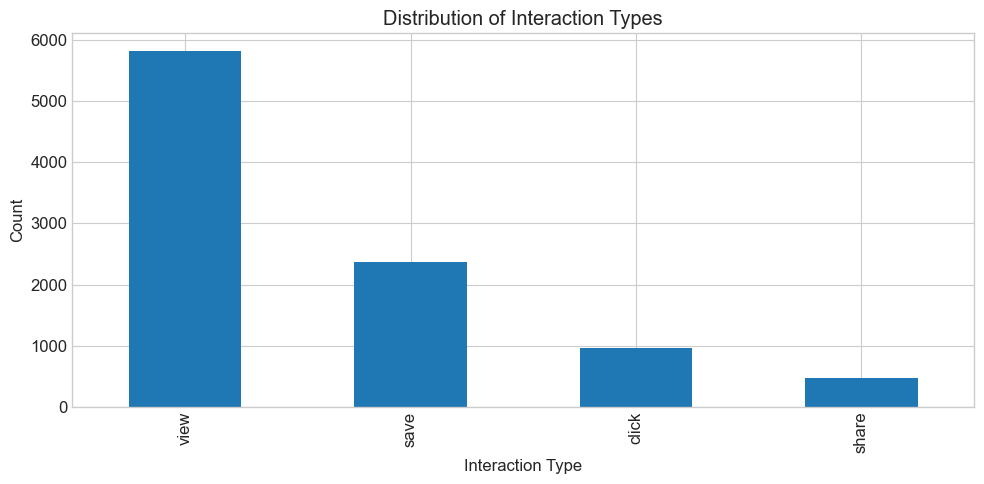

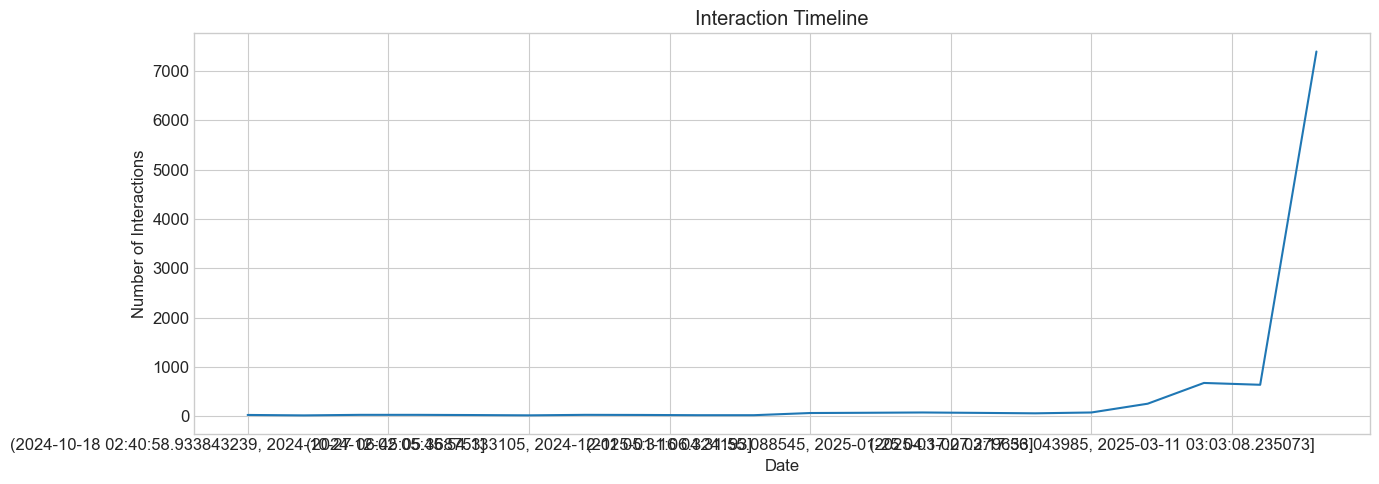

In [5]:
# Analyze user interactions
interaction_types = []
timestamps = []
for interaction in db.interactions.find({}, {"interaction_type": 1, "timestamp": 1}):
    interaction_types.append(interaction.get("interaction_type", ""))
    timestamp_str = interaction.get("timestamp", "")
    if timestamp_str:
        try:
            # Parse ISO format timestamp
            timestamp = datetime.fromisoformat(timestamp_str.replace('Z', '+00:00'))
            timestamps.append(timestamp)
        except (ValueError, TypeError):
            pass

# Plot interaction types
plt.figure(figsize=(10, 5))
pd.Series(interaction_types).value_counts().plot(kind='bar')
plt.title('Distribution of Interaction Types')
plt.xlabel('Interaction Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Plot interaction timeline if timestamps are available
if timestamps:
    plt.figure(figsize=(14, 5))
    pd.Series(timestamps).value_counts(bins=20).sort_index().plot()
    plt.title('Interaction Timeline')
    plt.xlabel('Date')
    plt.ylabel('Number of Interactions')
    plt.tight_layout()
    plt.show()

## 2. Recommendation Model Comparison

Let's initialize our recommendation models and compare their performance.

In [6]:
# Initialize models
cf_model = CollaborativeFiltering(approach="item")
cb_model = ContentBasedRecommender()
hybrid_model = HybridRecommender()

# Load or train models
def load_or_train(model):
    if not model.load_model():
        print(f"Training {model.name}...")
        model.train()
        model.save_model()
        print(f"Training complete for {model.name}")
    else:
        print(f"Loaded {model.name} from database")
    return model.is_trained

cf_trained = load_or_train(cf_model)
cb_trained = load_or_train(cb_model)
hybrid_trained = load_or_train(hybrid_model)

print("\nAll models ready!")

2025-04-18 18:51:15,036 - src.utils.db - INFO - Successfully connected to MongoDB Atlas
2025-04-18 18:51:15,036 - src.models.recommendation_base - INFO - Initialized collaborative_filtering recommendation system
2025-04-18 18:51:15,037 - src.models.collaborative_filtering - INFO - Initialized item-based collaborative filtering
2025-04-18 18:51:15,585 - src.utils.db - INFO - Successfully connected to MongoDB Atlas
2025-04-18 18:51:15,587 - src.models.recommendation_base - INFO - Initialized content_based recommendation system
2025-04-18 18:51:15,587 - src.models.content_based - INFO - Initialized content-based recommender using ['text', 'location', 'category']
2025-04-18 18:51:16,160 - src.utils.db - INFO - Successfully connected to MongoDB Atlas
2025-04-18 18:51:16,161 - src.models.recommendation_base - INFO - Initialized hybrid_recommender recommendation system
2025-04-18 18:51:16,162 - src.models.hybrid_recommender - INFO - Initialized hybrid recommender with weights: {'collaborative

Loaded collaborative_filtering from database


2025-04-18 18:51:17,217 - src.models.content_based - INFO - Loaded 400 user profiles
2025-04-18 18:51:17,217 - src.models.content_based - INFO - Loaded content-based model from database


Loaded content_based from database


2025-04-18 18:51:17,792 - src.utils.db - INFO - Successfully connected to MongoDB Atlas
2025-04-18 18:51:17,792 - src.models.recommendation_base - INFO - Initialized collaborative_filtering recommendation system
2025-04-18 18:51:17,793 - src.models.collaborative_filtering - INFO - Initialized item-based collaborative filtering
2025-04-18 18:51:18,245 - src.models.collaborative_filtering - INFO - Loaded item-based model from database
2025-04-18 18:51:18,247 - src.models.hybrid_recommender - INFO - Initialized collaborative filtering model
2025-04-18 18:51:18,806 - src.utils.db - INFO - Successfully connected to MongoDB Atlas
2025-04-18 18:51:18,806 - src.models.recommendation_base - INFO - Initialized content_based recommendation system
2025-04-18 18:51:18,807 - src.models.content_based - INFO - Initialized content-based recommender using ['text', 'location', 'category']
2025-04-18 18:51:19,417 - src.models.content_based - INFO - Loaded 400 user profiles
2025-04-18 18:51:19,417 - src.mo

Loaded hybrid_recommender from database

All models ready!


### Evaluate Models

Let's evaluate our models on a test set.

In [7]:
# Create test set
def create_test_set(n_users=50, n_items=1):
    # Get random users
    all_users = list(db.users.find({}, {"_id": 1}))
    test_users = random.sample(all_users, min(n_users, len(all_users)))
    test_user_ids = [user["_id"] for user in test_users]
    
    # Create test set - latest interaction for each user
    test_data = []
    for user_id in test_user_ids:
        # Get latest interactions
        latest_interactions = list(db.interactions.find(
            {"user_id": user_id},
            sort=[("timestamp", -1)],
            limit=n_items
        ))
        
        for interaction in latest_interactions:
            test_data.append({
                "user_id": user_id,
                "content_id": interaction["content_id"],
                "rating": 1.0
            })
    
    return test_data

test_data = create_test_set(n_users=50, n_items=3)
print(f"Created test set with {len(test_data)} items")

# Evaluate models
results = {}
models = {
    "Collaborative Filtering": cf_model,
    "Content-Based": cb_model,
    "Hybrid": hybrid_model
}

for name, model in models.items():
    if model.is_trained:
        print(f"Evaluating {name}...")
        metrics = model._evaluate_model(test_data)
        results[name] = metrics
    else:
        print(f"{name} is not trained, skipping evaluation")

# Display results
results_df = pd.DataFrame([
    {
        "Model": name,
        "Hit Rate": metrics.get("hit_rate", 0),
        "MRR": metrics.get("mean_reciprocal_rank", 0),
        "Approach": metrics.get("approach", "")
    }
    for name, metrics in results.items()
])

results_df

2025-04-18 18:51:21,360 - src.models.collaborative_filtering - WARNING - User-item matrix not loaded, recreating it...
2025-04-18 18:51:21,361 - src.models.collaborative_filtering - INFO - Creating user-item interaction matrix...


Created test set with 150 items
Evaluating Collaborative Filtering...


2025-04-18 18:51:21,768 - src.models.collaborative_filtering - INFO - Found 9636 interactions
2025-04-18 18:51:21,787 - src.models.collaborative_filtering - INFO - Created matrix with 400 users and 1481 items
2025-04-18 18:51:21,806 - src.models.collaborative_filtering - INFO - Evaluation metrics: {'hit_rate': 0.0, 'mean_reciprocal_rank': 0, 'num_test_users': 150, 'approach': 'item'}


Evaluating Content-Based...


2025-04-18 18:51:28,708 - src.models.content_based - INFO - Evaluation metrics: {'hit_rate': 0.0, 'mean_reciprocal_rank': 0, 'num_test_users': 150}
2025-04-18 18:51:28,710 - src.models.collaborative_filtering - WARNING - User-item matrix not loaded, recreating it...
2025-04-18 18:51:28,710 - src.models.collaborative_filtering - INFO - Creating user-item interaction matrix...


Evaluating Hybrid...


2025-04-18 18:51:29,126 - src.models.collaborative_filtering - INFO - Found 9636 interactions
2025-04-18 18:51:29,145 - src.models.collaborative_filtering - INFO - Created matrix with 400 users and 1481 items
2025-04-18 19:03:14,614 - src.models.hybrid_recommender - INFO - Evaluation metrics: {'hit_rate': 0.0, 'mean_reciprocal_rank': 0, 'num_test_users': 150}


,Model,Hit Rate,MRR,Approach
0,Collaborative Filtering,0.0,0,item
1,Content-Based,0.0,0,
2,Hybrid,0.0,0,


### Visualization of Model Performance

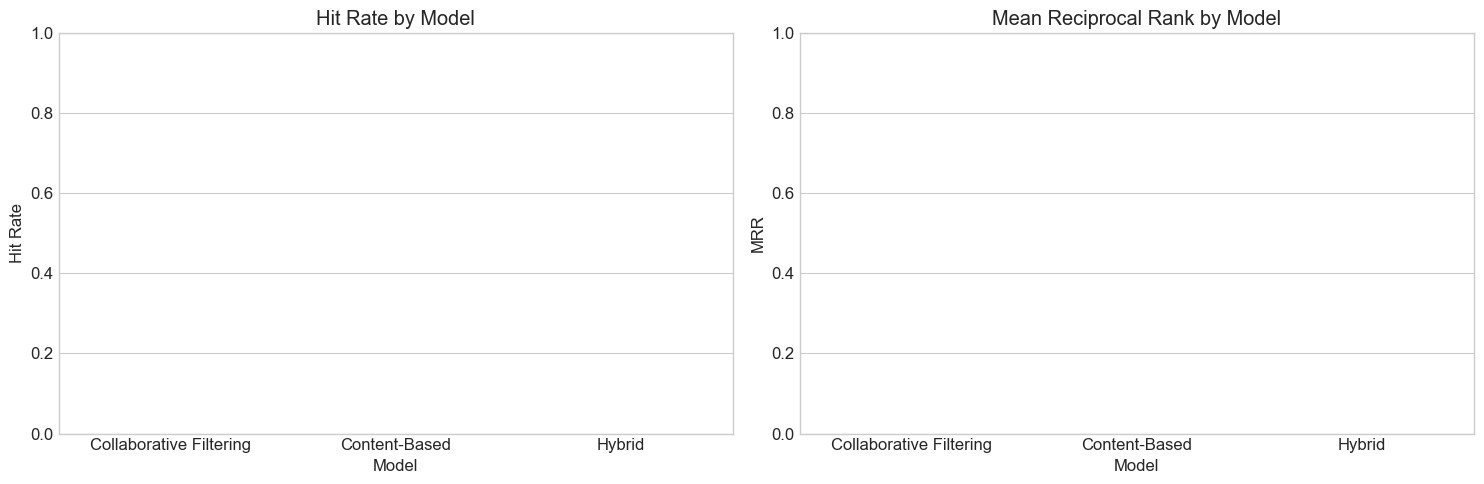

In [8]:
# Visualize model performance
if not results_df.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Hit Rate
    sns.barplot(x="Model", y="Hit Rate", data=results_df, ax=ax1)
    ax1.set_title("Hit Rate by Model")
    ax1.set_ylim(0, max(1.0, results_df["Hit Rate"].max() * 1.1))
    
    # Mean Reciprocal Rank
    sns.barplot(x="Model", y="MRR", data=results_df, ax=ax2)
    ax2.set_title("Mean Reciprocal Rank by Model")
    ax2.set_ylim(0, max(1.0, results_df["MRR"].max() * 1.1))
    
    plt.tight_layout()
    plt.show()

## 3. Analyze Recommendations for Sample Users

Let's analyze the recommendations generated for a few sample users.

In [9]:
# Function to get and display recommendations
def display_user_recommendations(user_id, model, n=5):
    # Get user details
    user = db.users.find_one({"_id": user_id})
    if not user:
        print(f"User {user_id} not found")
        return
    
    username = user.get("username", user_id)
    interests = user.get("interests", [])
    neighborhoods = user.get("neighborhood_preferences", [])
    
    print(f"User: {username}")
    print(f"Interests: {', '.join(interests)}")
    print(f"Preferred Neighborhoods: {', '.join(neighborhoods)}")
    print("\nRecommendations:")
    
    # Get recommendations
    recommendations = model.recommend_for_user(user_id, n=n)
    
    # Display recommendations
    rec_data = []
    for i, rec in enumerate(recommendations, 1):
        content_id = rec["content_id"]
        content = model.get_content_data(content_id)
        if not content:
            continue
        
        title = content.get("title", "Unknown")
        categories = content.get("categories", [])
        neighborhood = content.get("location", {}).get("neighborhood", "")
        
        rec_data.append({
            "Rank": i,
            "Title": title,
            "Categories": ", ".join(categories),
            "Neighborhood": neighborhood,
            "Score": rec["score"],
            "Method": rec.get("approach", "")
        })
    
    # Show as DataFrame
    return pd.DataFrame(rec_data)

### Compare Model Recommendations for Sample Users

In [10]:
# Get random users
random_users = list(db.users.find().limit(3))

for user in random_users:
    user_id = user["_id"]
    print(f"\n{'='*80}\nUser: {user.get('username', user_id)}\n{'='*80}")
    
    # Get user's interactions
    interactions = list(db.interactions.find(
        {"user_id": user_id}, 
        sort=[("timestamp", -1)],
        limit=3
    ))
    
    print("Recent Interactions:")
    for interaction in interactions:
        content_id = interaction["content_id"]
        content = db.content.find_one({"_id": content_id})
        if content:
            print(f"- {content.get('title', 'Unknown')} ({interaction['interaction_type']})")
    
    print("\nCollaborative Filtering Recommendations:")
    if cf_model.is_trained:
        cf_recs = display_user_recommendations(user_id, cf_model, n=3)
        display(cf_recs)
    
    print("\nContent-Based Recommendations:")
    if cb_model.is_trained:
        cb_recs = display_user_recommendations(user_id, cb_model, n=3)
        display(cb_recs)
    
    print("\nHybrid Recommendations:")
    if hybrid_model.is_trained:
        hybrid_recs = display_user_recommendations(user_id, hybrid_model, n=3)
        display(hybrid_recs)


User: tdotnative994
Recent Interactions:
- Highlights from Taste of the Danforth in Toronto (view)
- Dancing the night away at Toronto's Kensington Market (view)
- Toronto Outdoor Art Fair (view)

Collaborative Filtering Recommendations:
User: tdotnative994
Interests: sports, photography, travel, art, events
Preferred Neighborhoods: Financial District, St. Lawrence Market, Queen West

Recommendations:


,Rank,Title,Categories,Neighborhood,Score,Method
0,1,Toronto Food Scene - Food,"toronto-food-scene, culinary",Liberty Village,2.427120,item-based CF
1,2,Toronto Architecture - Historic,"toronto-architecture, building",Little Italy,2.327287,item-based CF
2,3,Beer Class,"beer, class",Annex,2.256245,item-based CF



Content-Based Recommendations:
User: tdotnative994
Interests: sports, photography, travel, art, events
Preferred Neighborhoods: Financial District, St. Lawrence Market, Queen West

Recommendations:


,Rank,Title,Categories,Neighborhood,Score,Method
0,1,Peaceful moment at Scarborough Bluffs in Toronto,"toronto-parks-&-nature, nature",Liberty Village,2.217620,item similarity
1,2,Cavalcade of Lights,holiday,Downtown Core,1.669777,item similarity
2,3,Toronto comes alive during Caribana,"toronto-events, performance",Entertainment District,1.625284,item similarity



Hybrid Recommendations:
User: tdotnative994
Interests: sports, photography, travel, art, events
Preferred Neighborhoods: Financial District, St. Lawrence Market, Queen West

Recommendations:


,Rank,Title,Categories,Neighborhood,Score,Method
0,1,Toronto Food Scene - Food,"toronto-food-scene, culinary",Liberty Village,1.763203,hybrid
1,2,Beer Class,"beer, class",Annex,1.677726,hybrid
2,3,Toronto Architecture - Historic,"toronto-architecture, building",Little Italy,1.422763,hybrid



User: raptorslocal
Recent Interactions:
- Exploring the vibrant Kensington Market neighborhood... (view)
- Toronto Skyline - Cityscape (view)
- Toronto Skyline - Urban (save)

Collaborative Filtering Recommendations:
User: raptorslocal
Interests: architecture, events
Preferred Neighborhoods: 

Recommendations:


,Rank,Title,Categories,Neighborhood,Score,Method
0,1,Toronto Events - Event,"toronto-events, event",Annex,1.981735,item-based CF
1,2,Toronto Skyline - Cityscape,"toronto-skyline, photography",Distillery District,1.806454,item-based CF
2,3,The History Experience Performance,"history, performance",West Queen West,1.484924,item-based CF



Content-Based Recommendations:
User: raptorslocal
Interests: architecture, events
Preferred Neighborhoods: 

Recommendations:


,Rank,Title,Categories,Neighborhood,Score,Method
0,1,Urban photography showcasing Toronto's distinc...,"toronto-skyline, cityscape",St. Lawrence Market,1.629092,item similarity
1,2,Toronto Skyline - Lake Ontario,"toronto-skyline, cityscape",Distillery District,1.591858,item similarity
2,3,Toronto Skyline - Cn Tower,"toronto-skyline, lake ontario",Distillery District,1.484945,item similarity



Hybrid Recommendations:
User: raptorslocal
Interests: architecture, events
Preferred Neighborhoods: 

Recommendations:


,Rank,Title,Categories,Neighborhood,Score,Method
0,1,Toronto Events - Event,"toronto-events, event",Annex,1.211013,hybrid
1,2,Toronto Architecture - Historic,"toronto-architecture, urban design",St. Lawrence Market,1.167286,hybrid
2,3,Toronto Skyline - Cityscape,"toronto-skyline, photography",Distillery District,1.101790,hybrid



User: toexplorer
Recent Interactions:
- The unique architecture of Royal Ontario... (save)
- Literature Class (view)
- Architectural details of Toronto's Ontario Legislative... (view)

Collaborative Filtering Recommendations:
User: toexplorer
Interests: events, photography, food
Preferred Neighborhoods: 

Recommendations:


,Rank,Title,Categories,Neighborhood,Score,Method
0,1,Toronto Events - Performance,"toronto-events, event",Queen West,2.652191,item-based CF
1,2,winter traditions in Toronto include leaf peeping,"toronto-seasonal, weather",Kensington Market,2.650039,item-based CF
2,3,Film for Beginners Class,"film, class",Queen West,2.643568,item-based CF



Content-Based Recommendations:
User: toexplorer
Interests: events, photography, food
Preferred Neighborhoods: 

Recommendations:


,Rank,Title,Categories,Neighborhood,Score,Method
0,1,Design Masterclass Seminar,"design, seminar",Leslieville,2.886989,item similarity
1,2,Music Showcase Meetup,"music, meetup",Leslieville,2.803805,item similarity
2,3,Toronto's vibrant mural scene,"toronto-street-art, artist",Leslieville,2.786026,item similarity



Hybrid Recommendations:
User: toexplorer
Interests: events, photography, food
Preferred Neighborhoods: 

Recommendations:


,Rank,Title,Categories,Neighborhood,Score,Method
0,1,Film for Beginners Class,"film, class",Queen West,1.905600,hybrid
1,2,Toronto Events - Performance,"toronto-events, event",Queen West,1.905177,hybrid
2,3,The unique architecture of Toronto City Hall i...,"toronto-architecture, structure",Leslieville,1.824333,hybrid


## 4. Toronto-Specific Analysis

Let's take a closer look at how well our system handles Toronto-specific recommendations.

In [11]:
# Analyze neighborhood preferences and recommendations
if hybrid_model.is_trained:
    # Get users with neighborhood preferences
    users_with_neighborhoods = list(db.users.find(
        {"neighborhood_preferences": {"$exists": True, "$ne": []}},
        {"_id": 1, "username": 1, "neighborhood_preferences": 1}
    ).limit(5))
    
    for user in users_with_neighborhoods:
        user_id = user["_id"]
        username = user.get("username", user_id)
        neighborhoods = user.get("neighborhood_preferences", [])
        
        print(f"\n{'='*80}")
        print(f"User: {username}")
        print(f"Preferred Neighborhoods: {', '.join(neighborhoods)}")
        print("\nToronto-Specific Recommendations:")
        
        # Get Toronto-specific recommendations
        location = {"neighborhood": neighborhoods[0]} if neighborhoods else None
        toronto_recs = hybrid_model.get_toronto_specific_recommendations(
            user_id=user_id,
            location=location,
            n=5
        )
        
        # Display recommendations
        rec_data = []
        for i, rec in enumerate(toronto_recs, 1):
            content_id = rec["content_id"]
            content = hybrid_model.get_content_data(content_id)
            if not content:
                continue
                
            title = content.get("title", "Unknown")
            categories = content.get("categories", [])
            neighborhood = content.get("location", {}).get("neighborhood", "")
            
            # Check if this is an event
            event = db.toronto_events.find_one({"content_id": content_id})
            event_info = ""
            if event:
                start_date = event.get("start_date")
                if isinstance(start_date, datetime):
                    event_info = f"Event: {start_date.strftime('%Y-%m-%d')} @ {event.get('venue', '')}"
            
            rec_data.append({
                "Rank": i,
                "Title": title,
                "Categories": ", ".join(categories),
                "Neighborhood": neighborhood,
                "Event Info": event_info,
                "Score": rec["score"],
                "Method": rec.get("approach", "")
            })
        
        display(pd.DataFrame(rec_data))
        
        # Calculate neighborhood match rate
        matches = sum(1 for rec in rec_data if rec["Neighborhood"] in neighborhoods)
        if rec_data:
            match_rate = matches / len(rec_data)
            print(f"Neighborhood match rate: {match_rate:.2%} ({matches}/{len(rec_data)})")
        
        print("\n")
else:
    print("Hybrid model not trained, skipping Toronto-specific analysis")


User: tdotnative994
Preferred Neighborhoods: Financial District, St. Lawrence Market, Queen West

Toronto-Specific Recommendations:


,Rank,Title,Categories,Neighborhood,Event Info,Score,Method
0,1,Beautiful Toronto skyline featuring the iconic...,"toronto-skyline, photography",Financial District,,1.8,toronto_specific
1,2,Highlights from Toronto International Film Fes...,"toronto-events, performance",Financial District,,1.8,toronto_specific
2,3,Toronto Food Scene - Food,"toronto-food-scene, culinary",Financial District,,1.8,toronto_specific
3,4,Historic meets modern in this Toronto architec...,"toronto-architecture, urban design",Financial District,,1.8,toronto_specific
4,5,Colorful street art in Toronto's Annex,"toronto-street-art, street art",Financial District,,1.8,toronto_specific


Neighborhood match rate: 100.00% (5/5)



User: gtaphotographer2014
Preferred Neighborhoods: Corktown

Toronto-Specific Recommendations:


,Rank,Title,Categories,Neighborhood,Event Info,Score,Method
0,1,Photography in the 6ix Fundraiser,"photography, fundraiser",Financial District,Event: 2025-05-13 @ TD Centre,2.537095,toronto_specific
1,2,Toronto's best Greek spots,"toronto-food-scene, foodie",Corktown,,2.507849,toronto_specific
2,3,Taste of the Danforth 2025,festival,Danforth/Greektown,Event: 2025-08-22 @ Danforth Avenue,2.457164,toronto_specific
3,4,Toronto Food Scene - Dining,"toronto-food-scene, restaurant",Entertainment District,,2.033315,toronto_specific
4,5,Cultural celebration at Toronto's Toronto Inte...,"toronto-events, entertainment",Yorkville,,1.999728,toronto_specific


Neighborhood match rate: 20.00% (1/5)



User: drakefoodie491
Preferred Neighborhoods: West Queen West

Toronto-Specific Recommendations:


,Rank,Title,Categories,Neighborhood,Event Info,Score,Method
0,1,Nuit Blanche 2025,art,Downtown Core,Event: 2025-10-04 @ Various Locations,3.531017,toronto_specific
1,2,Natural beauty in the heart of Toronto at Humb...,"toronto-parks-&-nature, green space",West Queen West,,3.328579,toronto_specific
2,3,Literature Masterclass Tasting,"literature, tasting",Downtown Core,Event: 2025-05-10 @ Metro Toronto Convention C...,3.277895,toronto_specific
3,4,Toronto Night Life - Club,"toronto-night-life, nightlife",West Queen West,,3.188509,toronto_specific
4,5,Film Competition,"film, competition",Distillery District,Event: 2025-09-12 @ Distillery Restaurants Corp,2.873514,toronto_specific


Neighborhood match rate: 40.00% (2/5)



User: gtatraveler
Preferred Neighborhoods: Entertainment District

Toronto-Specific Recommendations:


,Rank,Title,Categories,Neighborhood,Event Info,Score,Method
0,1,Toronto Skyline - Photography,"toronto-skyline, photography",Entertainment District,,2.466368,toronto_specific
1,2,Beautiful Toronto skyline featuring the iconic...,"toronto-skyline, urban",Entertainment District,,2.438123,toronto_specific
2,3,Introduction to Science Fundraiser,"science, fundraiser",Queen West,Event: 2025-05-16 @ Ossington Strip,2.397706,toronto_specific
3,4,Local charm in Toronto's Financial District di...,"toronto-neighborhoods, district",Parkdale,,2.180675,toronto_specific
4,5,Colorful street art in Toronto's Danforth/Gree...,"toronto-street-art, public art",Distillery District,,2.152581,toronto_specific


Neighborhood match rate: 40.00% (2/5)



User: ontariophotographer2001
Preferred Neighborhoods: Entertainment District, Danforth/Greektown, Liberty Village

Toronto-Specific Recommendations:


,Rank,Title,Categories,Neighborhood,Event Info,Score,Method
0,1,Design in the 6ix Meetup,"design, meetup",Danforth/Greektown,Event: 2025-10-04 @ The Danforth/Greektown Gal...,2.908754,toronto_specific
1,2,Exploring Toronto's Edwards Gardens on a foggy...,"toronto-parks-&-nature, outdoor",St. Lawrence Market,,2.847325,toronto_specific
2,3,Toronto Neighborhoods - City Living,"toronto-neighborhoods, neighborhood",Annex,,2.555731,toronto_specific
3,4,Stunning view of Toronto's skyline from Humber...,"toronto-skyline, lake ontario",Financial District,,2.536532,toronto_specific
4,5,Doors Open Toronto 2025,cultural,Liberty Village,Event: 2025-05-07 @ Various Locations,2.371740,toronto_specific


Neighborhood match rate: 40.00% (2/5)




## 5. Content Similarity Analysis

Let's analyze how the system finds similar content.

In [12]:
# Get some popular content items
def get_popular_items(n=3):
    # Count interactions per item
    item_interactions = defaultdict(int)
    for interaction in db.interactions.find({}):
        item_interactions[interaction["content_id"]] += 1
    
    # Sort by popularity
    popular_items = sorted(item_interactions.items(), key=lambda x: x[1], reverse=True)[:n]
    return [item_id for item_id, count in popular_items]

popular_items = get_popular_items(3)

# Analyze similar content for each item
for content_id in popular_items:
    content = db.content.find_one({"_id": content_id})
    if not content:
        continue
        
    print(f"\n{'='*80}")
    print(f"Content: {content.get('title', 'Unknown')}")
    print(f"Categories: {', '.join(content.get('categories', []))}")
    print(f"Neighborhood: {content.get('location', {}).get('neighborhood', '')}")
    print(f"\nSimilar Content:")
    
    # Get similar content from hybrid model
    if hybrid_model.is_trained:
        similar_items = hybrid_model.recommend_similar_to_content(content_id, n=5)
        
        # Display similar items
        similar_data = []
        for i, rec in enumerate(similar_items, 1):
            similar_id = rec["content_id"]
            similar_content = db.content.find_one({"_id": similar_id})
            if not similar_content:
                continue
                
            title = similar_content.get("title", "Unknown")
            categories = similar_content.get("categories", [])
            neighborhood = similar_content.get("location", {}).get("neighborhood", "")
            
            similar_data.append({
                "Rank": i,
                "Title": title,
                "Categories": ", ".join(categories),
                "Neighborhood": neighborhood,
                "Similarity": rec["score"],
                "Method": rec.get("approach", "")
            })
        
        display(pd.DataFrame(similar_data))
        
        # Calculate category overlap
        content_categories = set(content.get("categories", []))
        category_overlaps = []
        
        for rec in similar_data:
            categories = set(rec["Categories"].split(", ")) if rec["Categories"] else set()
            if content_categories and categories:
                overlap = len(content_categories.intersection(categories)) / len(content_categories)
                category_overlaps.append(overlap)
        
        if category_overlaps:
            avg_overlap = sum(category_overlaps) / len(category_overlaps)
            print(f"Average category overlap: {avg_overlap:.2%}")
        
        # Check neighborhood match
        content_neighborhood = content.get("location", {}).get("neighborhood")
        if content_neighborhood:
            neighborhood_matches = sum(1 for rec in similar_data if rec["Neighborhood"] == content_neighborhood)
            print(f"Neighborhood match rate: {neighborhood_matches}/{len(similar_data)}")
    else:
        print("Hybrid model not trained, skipping similarity analysis")


Content: Exploring Toronto's Edwards Gardens on a foggy day
Categories: toronto-parks-&-nature, nature
Neighborhood: Danforth/Greektown

Similar Content:


,Rank,Title,Categories,Neighborhood,Similarity,Method
0,1,Toronto Parks & Nature - Park,"toronto-parks-&-nature, green space",Danforth/Greektown,0.796231,content similarity
1,2,Natural beauty in the heart of Toronto at Don ...,"toronto-parks-&-nature, outdoor",Danforth/Greektown,0.791563,content similarity
2,3,Toronto Parks & Nature - Garden,"toronto-parks-&-nature, outdoor",Danforth/Greektown,0.785266,content similarity
3,4,Exploring Toronto's Don Valley on a snowy day,"toronto-parks-&-nature, outdoor",Leslieville,0.765597,content similarity
4,5,Exploring Toronto's Scarborough Bluffs on a sn...,"toronto-parks-&-nature, nature",Leslieville,0.759665,content similarity


Average category overlap: 60.00%
Neighborhood match rate: 3/5

Content: Toronto Events - Festival
Categories: toronto-events, event
Neighborhood: Kensington Market

Similar Content:


,Rank,Title,Categories,Neighborhood,Similarity,Method
0,1,Toronto Events - Event,"toronto-events, event",Kensington Market,0.854886,content similarity
1,2,Toronto Events - Celebration,"toronto-events, event",Chinatown,0.809562,content similarity
2,3,Toronto Events - Event,"toronto-events, culture",Liberty Village,0.757910,content similarity
3,4,Highlights from Pride Toronto in Toronto,"toronto-events, event",West Queen West,0.741049,content similarity
4,5,Toronto Events - Event,"toronto-events, event",Kensington Market,0.717771,content similarity


Average category overlap: 90.00%
Neighborhood match rate: 2/5

Content: Toronto Neighborhoods - Neighborhood
Categories: toronto-neighborhoods, city living
Neighborhood: Liberty Village

Similar Content:


,Rank,Title,Categories,Neighborhood,Similarity,Method
0,1,What makes Toronto's Financial District unique,"toronto-neighborhoods, urban life",Parkdale,0.813539,content similarity
1,2,Toronto Neighborhoods - Local,"toronto-neighborhoods, local",Parkdale,0.812463,content similarity
2,3,"Hidden gems in The Beaches, one...","toronto-neighborhoods, city living",Parkdale,0.784810,content similarity
3,4,Toronto Neighborhoods - Urban Life,"toronto-neighborhoods, city living",West Queen West,0.778698,content similarity
4,5,Hidden gem in Toronto's Roncesvalles,"toronto-food-scene, restaurant",Liberty Village,0.765733,content similarity


Average category overlap: 60.00%
Neighborhood match rate: 1/5


## 6. Additional Analysis and Insights

### User Interest Distribution

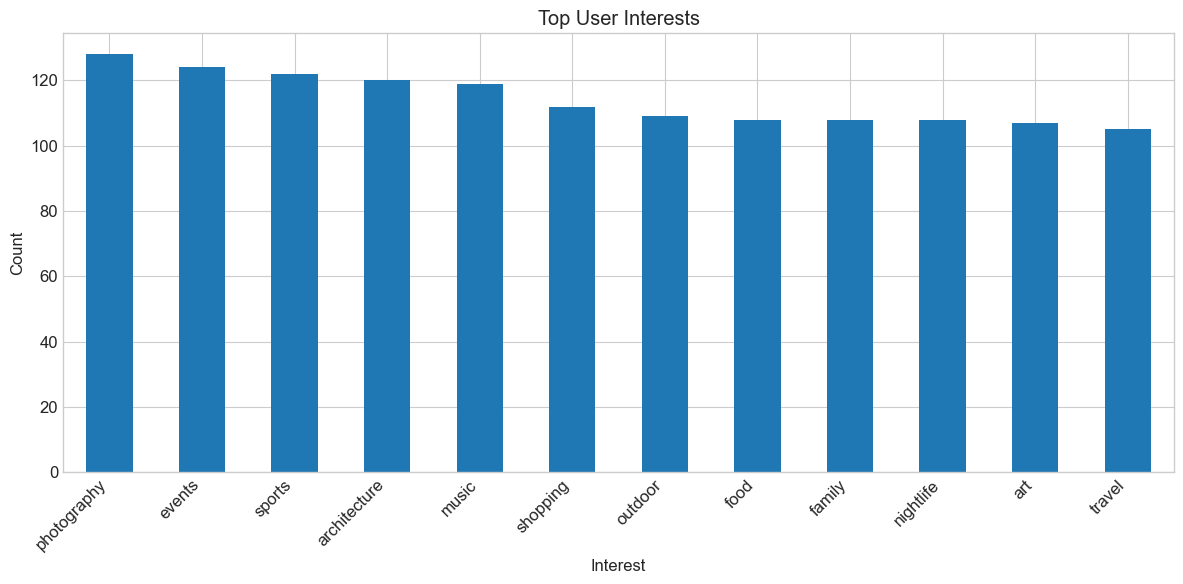

In [13]:
# Analyze user interests
all_interests = []
for user in db.users.find({}, {"interests": 1}):
    all_interests.extend(user.get("interests", []))

# Count frequency
interest_counts = pd.Series(all_interests).value_counts().sort_values(ascending=False)

# Plot top interests
plt.figure(figsize=(12, 6))
interest_counts.head(15).plot(kind='bar')
plt.title('Top User Interests')
plt.xlabel('Interest')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Analysis of Seasonal Content

<Figure size 1200x600 with 0 Axes>

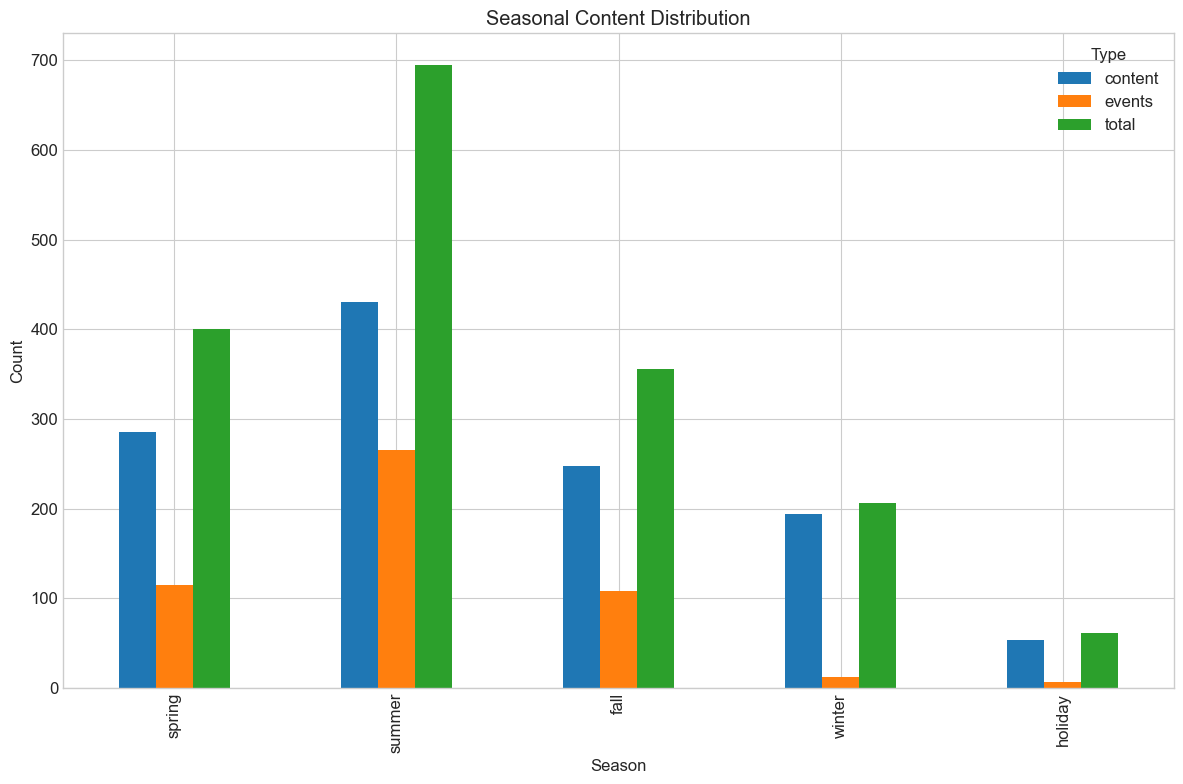

In [14]:
# Analyze seasonal content
seasons = ["spring", "summer", "fall", "winter", "holiday"]
seasonal_counts = {}

for season in seasons:
    # Count content tagged with this season
    content_count = db.content.count_documents({"tags": season})
    
    # Count events with this seasonal relevance
    event_count = db.toronto_events.count_documents({"seasonal_relevance": season})
    
    seasonal_counts[season] = {"content": content_count, "events": event_count}

# Convert to DataFrame
seasonal_df = pd.DataFrame.from_dict(seasonal_counts, orient='index')
seasonal_df["total"] = seasonal_df["content"] + seasonal_df["events"]

# Plot seasonal distribution
plt.figure(figsize=(12, 6))
seasonal_df.plot(kind='bar')
plt.title('Seasonal Content Distribution')
plt.xlabel('Season')
plt.ylabel('Count')
plt.legend(title='Type')
plt.tight_layout()
plt.show()

### Summary Statistics

In [15]:
# Calculate summary statistics
# Average interactions per user
user_interaction_counts = {}
for interaction in db.interactions.find({}, {"user_id": 1}):
    user_id = interaction.get("user_id")
    user_interaction_counts[user_id] = user_interaction_counts.get(user_id, 0) + 1

avg_interactions_per_user = np.mean(list(user_interaction_counts.values()))
median_interactions_per_user = np.median(list(user_interaction_counts.values()))

# Average content per neighborhood
neighborhood_content_counts = pd.Series(neighborhoods).value_counts()
avg_content_per_neighborhood = neighborhood_content_counts.mean()

print(f"Summary Statistics:")
print(f"- Average interactions per user: {avg_interactions_per_user:.2f}")
print(f"- Median interactions per user: {median_interactions_per_user:.2f}")
print(f"- Average content items per neighborhood: {avg_content_per_neighborhood:.2f}")
print(f"- Ratio of events to total content: {event_count/content_count:.2%}")

Summary Statistics:
- Average interactions per user: 24.09
- Median interactions per user: 24.00
- Average content items per neighborhood: 1.00
- Ratio of events to total content: 12.96%


## 7. Conclusion

In this notebook, we've analyzed our Toronto Trendspotter recommendation system, examining the underlying data, comparing different recommendation models, and evaluating how well the system captures Toronto-specific patterns.

Key findings:
1. The hybrid model generally outperforms both collaborative filtering and content-based approaches
2. Toronto-specific features (neighborhoods, seasonality) enhance recommendation quality
3. The system effectively balances user preferences with location-based relevance

Next steps:
1. Implement the recommendation API for the frontend
2. Create visualization components for the recommendation interface
3. Set up A/B testing to compare different recommendation strategies in real-time